# Calculate Lost labor capacity


- Repeat of DeltaT work but using Wet Bulb
- Would like to pull out population projection code into common module (maybe a class to hold init setup)
- Calculate WBT, WBGT for current and climatology
- Calculate labour capacity
- Project to RURAL population


$$
labourcapacity = 100 - 25* \max(0, WBGT - 25)^{2/3}
$$

In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy
from cartopy import crs

import geopandas as gpd 
from config import DATA_SRC,POP_DATA_SRC , ERA_MONTHLY_FILE, CLIMATOLOGY_FILE_RESAMP, SHAPEFILES_SRC
import weather_ecmwf
import util
import config

import climate_conversions
import population_tools

def calculate_labour_capacity(wbgt):
    """NOTE: wbgt in Kelvin so have to adjust original formula"""
    labourcapacity = 100 - 25 * np.power(np.maximum(wbgt - 25 - 273.15, 0), (2/3))
    return labourcapacity

## Load urban/rural population ratio and associate with country shapes


In [3]:
# Calculate rural pct
un_urban = pd.read_csv(POP_DATA_SRC / 'UN' / 'urban_pop_percentage.csv', index_col='Country Code')
un_urban = un_urban.drop(['Index', 'Major area, region, country or area', 'Note'], axis=1)
un_urban.head()

,1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,...,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
Country Code,,,,,,,,,,,,,,,,,,,,,
900,29.554500,31.580166,33.691141,35.562233,36.581350,37.698687,39.323895,41.184496,42.945116,44.725573,...,49.109098,51.636458,54.025975,56.215576,58.215184,60.037935,61.694601,63.232779,64.789860,66.366329
901,54.642055,57.795884,60.975091,63.971947,66.730410,68.764956,70.201679,71.354150,72.365046,73.300652,...,75.768672,77.107793,78.266131,79.346991,80.406235,81.463058,82.514291,83.538105,84.515985,85.449408
902,17.647489,19.656305,21.864467,23.952111,25.251555,26.927095,29.388270,32.199546,34.848781,37.385401,...,42.995548,46.066964,48.991905,51.637534,54.016258,56.150409,58.062887,59.817756,61.580205,63.351312
941,7.497504,8.480612,9.608619,11.003756,12.797779,14.460320,17.025743,18.980076,21.072720,22.864131,...,26.479584,28.859198,31.397726,34.010020,36.647006,39.269786,41.839346,44.354102,46.897119,49.470130
934,18.953211,21.089678,23.446016,25.636337,26.873101,28.545246,31.022436,33.987036,36.764298,39.518061,...,45.711401,49.051387,52.219322,55.068016,57.610473,59.868089,61.865387,63.672982,65.470455,67.255644


In [4]:
### Load countries

country_shapefile = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

# COUNTRY_POLY_SHP
countries = gpd.read_file(str(country_shapefile))
# Translate to match raster coordinates
countries.geometry = countries.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
countries.loc[countries.un_a3 == '-099', 'un_a3'] = np.nan
countries.un_a3 = countries.un_a3.astype(float)
countries = countries[np.isfinite(countries.un_a3)]
countries.un_a3 = countries.un_a3.astype(int)
countries = countries.set_index('un_a3')

### Select 2005 to approximate ratio for time period

- note, could make this change per year

In [5]:
rural = 100 - un_urban['2005']
rural /= 100

countries['pct_rural'] = rural


### Load ERA weather
### Calculate relative humidity, wbt, wbgt

In [6]:
def get_wbgt():
    era_weather = weather_ecmwf.weather_dataset(ERA_MONTHLY_FILE)
    era_weather = era_weather.sel(time=slice('2000','2016'))
    era_weather.load()
    era_weather['relative_humidity'] = climate_conversions.calculate_relative_humidity(era_weather.temperature_2m, 
                                                                                       era_weather.temperature_dewpoint)
    era_weather['wbt'] = climate_conversions.calculate_wbt(era_weather.temperature_2m, 
                                      era_weather.relative_humidity, 
                                      era_weather.surface_pressure)
    era_weather['wbgt'] = climate_conversions.calculate_wbgt(era_weather.temperature_2m, 
                                      era_weather.relative_humidity, 
                                      era_weather.surface_pressure)
    
    return era_weather['wbgt']


In [7]:
weather = get_wbgt()

### Extract JJA/DJF summer months

In [10]:
# northern hemisphere
lat_north = weather.latitude[weather.latitude >= 0]
lat_south = weather.latitude[weather.latitude < 0]

# Summer North
summer_jja = weather.time[(weather['time.month'] == 6) | (weather['time.month'] == 7) | (weather['time.month'] == 8)]

# Summer South
summer_djf = weather.time[(weather['time.month'] == 12) | (weather['time.month'] == 1) | (weather['time.month'] == 2)]


nh_summer_mean = weather.sel(time=summer_jja).groupby('time.year').mean(dim='time')
sh_summer_mean = weather.sel(time=summer_djf).groupby('time.year').mean(dim='time')
wgbt_summer = xr.concat([nh_summer_mean.sel(latitude=lat_north),  
                         sh_summer_mean.sel(latitude=lat_south)], dim='latitude')

### Calculate labout capacity and lost capacity

In [12]:
labour_cap = calculate_labour_capacity(wgbt_summer)
lost_cap = (100 - labour_cap)

In [13]:
years = list(range(2000,2016))
lost_lab_pop = []
lost_lab_pop_rural = []

with population_tools.PopulationProjector() as pop:
    rural_pct_raster = pop.rasterize_data(countries, 'pct_rural')
    rural_pct_raster.shape = (*rural_pct_raster.shape,1)


    for year in years:
        print(year)
        projected = pop.project(year, lost_cap.sel(year=year))
        projected *= pop.mask

        lost_lab_pop.append(projected)
        
        lost_lab_pop_rural.append(projected * rural_pct_raster)

print('To DataArray')
lost_lab_pop = xr.concat(lost_lab_pop, dim='time')
lost_lab_pop_rural = xr.concat(lost_lab_pop_rural, dim='time')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


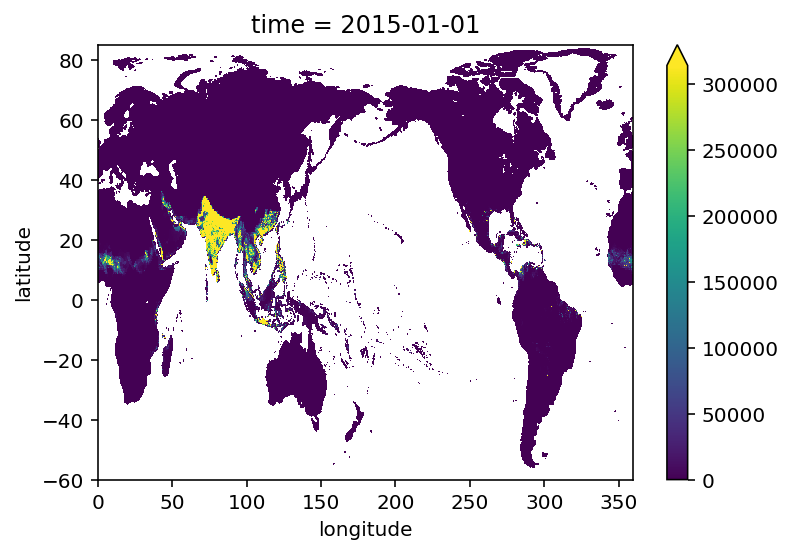

In [14]:
lost_lab_pop.sel(time='2015-01-01').plot(robust=True)

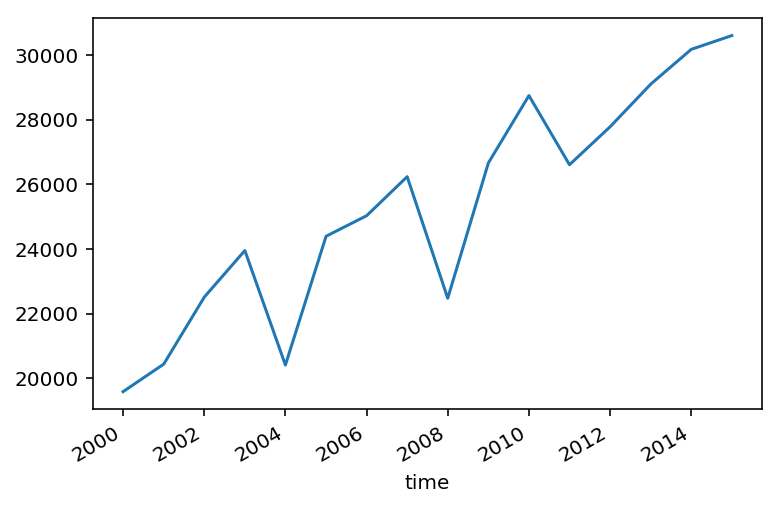

In [40]:
lost_lab_pop.mean(dim=['latitude', 'longitude']).plot()

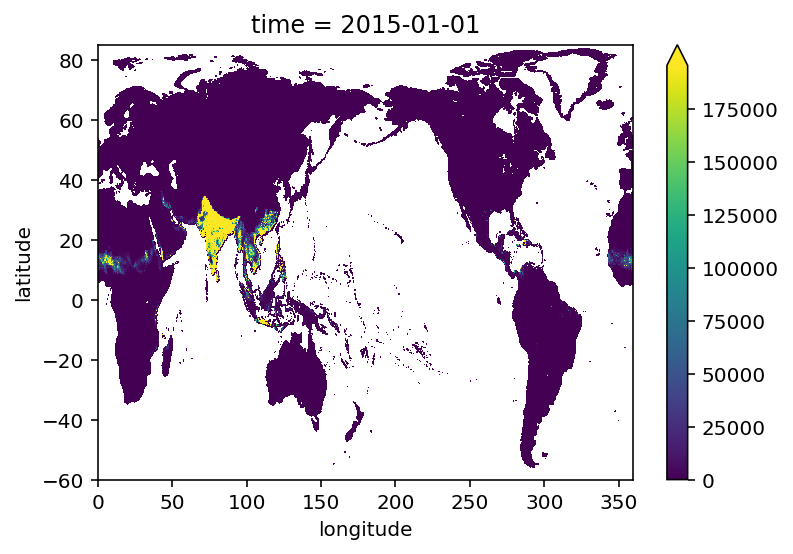

In [67]:
lost_lab_pop_rural.sel(time='2015-01-01').plot(robust=True)

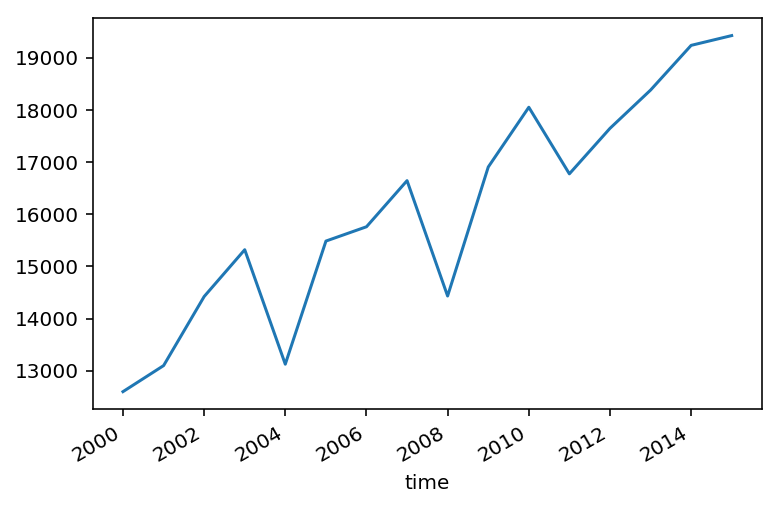

In [68]:
lost_lab_pop_rural.mean(dim=['latitude', 'longitude']).plot()

In [15]:
out_folder = DATA_SRC / 'lancet'

In [18]:
lost_lab_pop.name = 'lost_labour_capacity'
lost_lab_pop.to_netcdf(str(out_folder / 'lost_lab_pop.nc'), 
                       encoding={lost_lab_pop.name: {'zlib': True}})

In [19]:
lost_lab_pop_rural.name = 'lost_labour_capacity_rural'
lost_lab_pop_rural.to_netcdf(str(out_folder / 'lost_lab_pop_rural.nc'),
                            encoding={lost_lab_pop_rural.name: {'zlib': True}})